# IBM Data Science Capstone 
### Week 3 Comprehensive
- Build a pandas dataframe that includes: the postal code, Borough name and Neighborhood name for all Toronto neighborhoods
- Get the geographical coordinates (latitude, longitude) for each neighborhood in Toronto, Ontario, CA.
- Explore and cluster Toronto neighborhoods, using the previous NYC analysis as a model.
***
### 1. Import libraries

In [95]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print("Libraries imported.")

Libraries imported.


### 2. Scrape data from Wikipedia page into a dataframe

In [96]:
# send the GET request
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [97]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(data, 'html.parser')

In [98]:
# create three lists to store table data
postalCodeList = []
boroughList = []
neighborhoodList = []

In [99]:
# Using BeautifulSoup

# find the table
soup.find('table').find_all('tr')

# find all the rows of the table
soup.find('table').find_all('tr')

# for each row of the table, find all the table data
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')

In [100]:
# append the data into the respective lists
for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if(len(cells) > 0):
        postalCodeList.append(cells[0].text)
        boroughList.append(cells[1].text)
        neighborhoodList.append(cells[2].text.rstrip('\n')) # avoid new lines in neighborhood cell

In [101]:
# create a new DataFrame from the three lists
toronto_df = pd.DataFrame({"PostalCode": postalCodeList,
                           "Borough": boroughList,
                           "Neighborhood": neighborhoodList})

toronto_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### 3. Drop cells where 'Borough" is listed as "Not assigned."

In [102]:
# drop cells with a borough that is Not assigned
toronto_df_dropna = toronto_df[toronto_df.Borough != "Not assigned"].reset_index(drop=True)
toronto_df_dropna.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


### 4. Group neighborhoods in the same Borough

In [103]:
# group neighborhoods in the same borough
toronto_df_grouped = toronto_df_dropna.groupby(["PostalCode", "Borough"], as_index=False).agg(lambda x: ", ".join(x))
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### 5. For neighborhood listed as "Not assigned", designate a value that matches "Borough."

In [104]:
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in toronto_df_grouped.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
toronto_df_grouped.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### 6. Check the output for consistency.

In [105]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_grouped[toronto_df_grouped["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood
0,M5G,Downtown Toronto,Central Bay Street
1,M2H,North York,Hillcrest Village
2,M4B,East York,"Woodbine Gardens, Parkview Hill"
3,M1J,Scarborough,Scarborough Village
4,M4G,East York,Leaside
5,M4M,East Toronto,Studio District
6,M1R,Scarborough,"Maryvale, Wexford"
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
8,M9L,North York,Humber Summit
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo..."


### 7. Print the number of rows and columns in the cleaned dataframe.

In [106]:
# print the number of rows of the cleaned dataframe
toronto_df_grouped.shape

(103, 3)

### 8. Load geocoordinates (latitude, longitude) from the csv file on Coursera.

In [107]:
# load the coordinates from the csv file on Coursera
coordinates = pd.read_csv("Geospatial_Coordinates.csv")

In [108]:
# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 9. Merge the two tables to include: PostalCode, Borough, Neighborhood, Latitude, and Longitude. 

In [109]:
# merge two table on the column "PostalCode"
toronto_df_new = toronto_df_grouped.merge(coordinates, on="PostalCode", how="left")
toronto_df_new.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### 10. Check geocoordinates for consistency.

In [110]:
# create a new test dataframe
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_df_new[toronto_df_new["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Maryvale, Wexford",43.750072,-79.295849
7,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420


### 11. Use geopy library to get the latitude and longitude values of Toronto

In [111]:
import folium
m = folium.Map(location=[43.6532, -79.3832])

In [112]:
m

In [113]:
m.save('index.html')

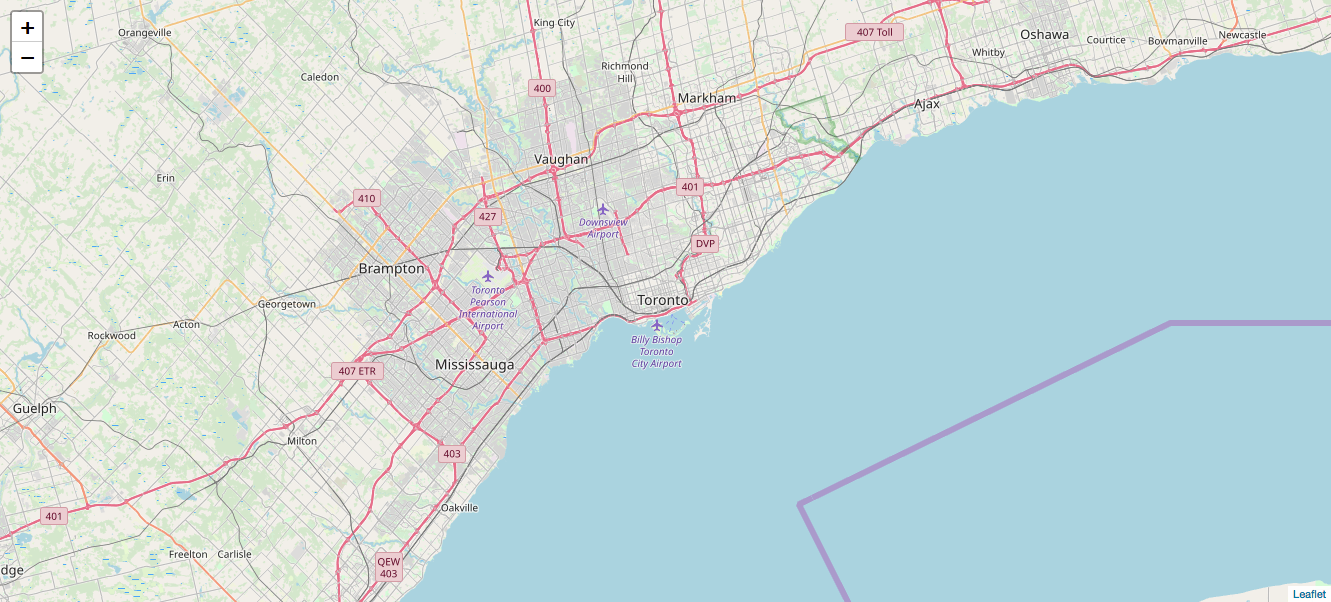

Map url: https://github.com/saracw/Coursera---IBM-Capstone-1/blob/master/torontomao.png

In [114]:
!pip install geopy

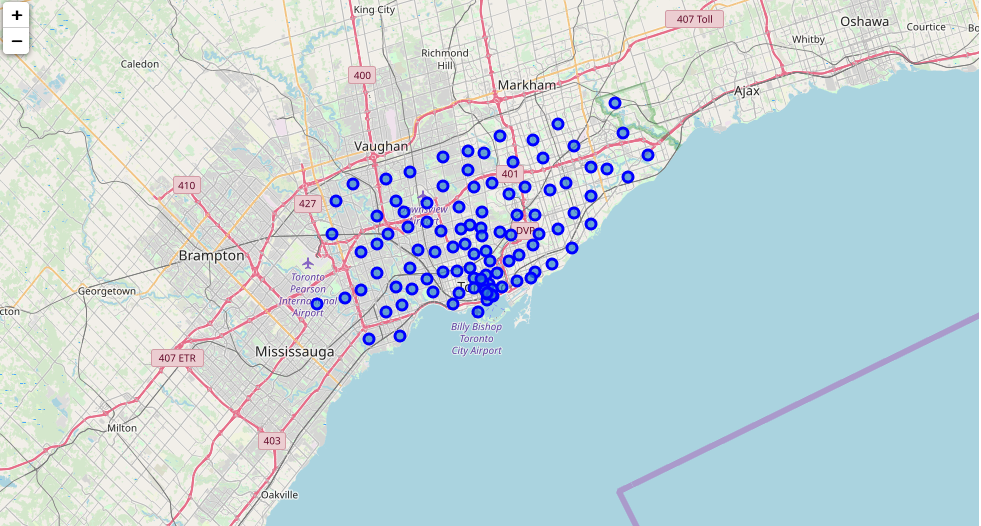

In [115]:
!conda install -c conda-forge folium  --yes
!pip install folium

print('Folium installed and imported!')

WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.

CondaHTTPError: HTTP 000 CONNECTION FAILED for url <https://conda.anaconda.org/conda-forge/osx-64/repodata.json>
Elapsed: -

An HTTP error occurred when trying to retrieve this URL.
HTTP errors are often intermittent, and a simple retry will get you on your way.
ConnectionError(ReadTimeoutError("HTTPSConnectionPool(host='conda.anaconda.org', port=443): Read timed out."))


Folium installed and imported!


In [116]:
!pip install geopy

In [117]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 12. Create a map of Toronto with Neighborhoods superimposed.

In [118]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto 

### 13. Filter to include only Boroughs that contain the word 'Toronto.' 

In [119]:
# filter borough names that contain the word Toronto
borough_names = list(toronto_df_new.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']

In [120]:
# create a new DataFrame with only boroughs that contain the word Toronto
toronto_df_new = toronto_df_new[toronto_df_new['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
print(toronto_df_new.shape)
toronto_df_new.head()

(38, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


### 14. Use the Foursquare API to explore Neighborhoods.

In [121]:
# define Foursquare Credentials and Version
CLIENT_ID = 'PKVKP4RSK1UDWBSX241ZZ2BFGZ2055XNG13MU1OZ5G4HO0FY' # your Foursquare ID
CLIENT_SECRET = 'IGWQRC4QT0EDQ0SSRIB4MEURVPRJ2TYL2LJP1BK55TZVGDIU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PKVKP4RSK1UDWBSX241ZZ2BFGZ2055XNG13MU1OZ5G4HO0FY
CLIENT_SECRET:IGWQRC4QT0EDQ0SSRIB4MEURVPRJ2TYL2LJP1BK55TZVGDIU


**Find the top 100 venues that are within a radius of 500 meters.**

In [122]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(toronto_df_new['Latitude'], toronto_df_new['Longitude'], toronto_df_new['PostalCode'], toronto_df_new['Borough'], toronto_df_new['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [123]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1701, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,M4E,East Toronto,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood


**How many venues were returned for each PostalCode?**

In [124]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,5,5,5,5,5,5
M4K,East Toronto,"The Danforth West, Riverdale",42,42,42,42,42,42
M4L,East Toronto,"The Beaches West, India Bazaar",18,18,18,18,18,18
M4M,East Toronto,Studio District,38,38,38,38,38,38
M4N,Central Toronto,Lawrence Park,3,3,3,3,3,3
M4P,Central Toronto,Davisville North,9,9,9,9,9,9
M4R,Central Toronto,North Toronto West,16,16,16,16,16,16
M4S,Central Toronto,Davisville,38,38,38,38,38,38
M4T,Central Toronto,"Moore Park, Summerhill East",2,2,2,2,2,2


**Content analysis: how many unique categories can found in the list of venues?**

In [125]:
print('There are {} unique categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 240 unique categories.


In [126]:
venues_df['VenueCategory'].unique()[:50]

array(['Trail', 'Health Food Store', 'Pub', 'Other Great Outdoors',
       'Neighborhood', 'Greek Restaurant', 'Ice Cream Shop',
       'Cosmetics Shop', 'Italian Restaurant', 'Brewery', 'Yoga Studio',
       'Dessert Shop', 'Fruit & Vegetable Store', 'Pizza Place',
       'Bookstore', 'Restaurant', 'Juice Bar', 'Bubble Tea Shop',
       'Furniture / Home Store', 'Indian Restaurant', 'Spa',
       'Grocery Store', 'Diner', 'Coffee Shop', 'Caribbean Restaurant',
       'Bakery', 'American Restaurant', 'Liquor Store', 'Café',
       'Fish & Chips Shop', 'Gym', 'Burger Joint', 'Park',
       'Sushi Restaurant', 'Steakhouse', 'Pet Store', 'Burrito Place',
       'Fast Food Restaurant', 'Movie Theater', 'Sandwich Place',
       'Fish Market', 'Cheese Shop', 'Comfort Food Restaurant',
       'Chinese Restaurant', 'Middle Eastern Restaurant',
       'Seafood Restaurant', 'Stationery Store', 'Coworking Space',
       'Gastropub', 'Bar'], dtype=object)

### 15. Take a closer look at each area.

In [127]:
# one hot encoding
toronto_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
toronto_onehot['PostalCode'] = venues_df['PostalCode'] 
toronto_onehot['Borough'] = venues_df['Borough'] 
toronto_onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehot.columns[-3:]) + list(toronto_onehot.columns[:-3])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1701, 243)


,PostalCode,Borough,Neighborhoods,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,M4E,East Toronto,Th

**Group the rows by Neighborhood, then compute mean occurrence by category**

In [128]:
toronto_grouped = toronto_onehot.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped

(38, 243)


,PostalCode,Borough,Neighborhoods,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.00,0.000000,0.000000,0.0000,0.0000,0.0000,0.000,0.000,0.000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.0000

**Now create a dataframe that displays the top 10 venues by PostalCode.**

In [129]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['PostalCode', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']
neighborhoods_venues_sorted['Borough'] = toronto_grouped['Borough']
neighborhoods_venues_sorted['Neighborhoods'] = toronto_grouped['Neighborhoods']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(38, 13)


,PostalCode,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,Health Food Store,Other Great Outdoors,Trail,Neighborhood,Pub,Ethiopian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market
1,M4K,East Toronto,"The Danforth West, Riverdale",Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bakery,Pub,Juice Bar,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",Park,Fast Food Restaurant,Ice Cream Shop,Brewery,Liquor Store,Fish & Chips Shop,Burger Joint,Burrito Place,Steakhouse,Sandwich Place
3,M4M,East Toronto,Studio District,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Gym / Fitness Center,Brewery,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
5,M4P,Central Toronto,Davisville North,Playground,Hotel,Food & Drink Shop,Clothing Store,Park,Sandwich Place,Grocery Store,Gym,Breakfast Spot,Event Space
6,M4R,Central Toronto,North Toronto West,Coffee Shop,Yoga Studio,Bagel Shop,Park,Clothing Store,Chinese Restaurant,Rental Car Location,Dessert Shop,Diner,Salon / Barbershop
7,M4S,Central Toronto,Davisville,Pizza Place,Dessert Shop,Sandwich Place,Café,Thai Restaurant,Restaurant,Italian Restaurant,Sushi Restaurant,Coffee Shop,Deli / Bodega
8,M4T,Central Toronto,"Moore Park, Summerhill East",Tennis Court,Playground,Comic Shop,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",Pub,Coffee Shop,American Restaurant,Light Rail Station,Fried Chicken Joint,Sushi Restaurant,Supermarket,Sports Bar,Bagel Shop,Liquor Store


### 16. Group into 5 clusters using KMeans cluster analysis.

In [130]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop(["PostalCode", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 0, 2, 2, 2, 1, 2], dtype=int32)

In [131]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = toronto_df_new.copy()

# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.drop(["Borough", "Neighborhoods"], 1).set_index("PostalCode"), on="PostalCode")

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(38, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Health Food Store,Other Great Outdoors,Trail,Neighborhood,Pub,Ethiopian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,2,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Bakery,Pub,Juice Bar,Caribbean Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,2,Park,Fast Food Restaurant,Ice Cream Shop,Brewery,Liquor Store,Fish & Chips Shop,Burger Joint,Burrito Place,Steakhouse,Sandwich Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Gastropub,Italian Restaurant,Bakery,American Restaurant,Yoga Studio,Gym / Fitness Center,Brewery,Seafood Restaurant
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


In [132]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged

(38, 16)


,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,1,Tennis Court,Playground,Comic Shop,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
21,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,2,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Steakhouse,Bakery,Gastropub,Seafood Restaurant,Deli / Bodega
24,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,2,Coffee Shop,Café,Sandwich Place,Pizza Place,History Museum,Indian Restaurant,Pharmacy,Cosmetics Shop,Pub,Burger Joint
25,M5S,Downtown Toronto,"Harbord, University of Toronto",43.662696,-79.400049,2,Café,Italian Restaurant,Bookstore,Restaurant,Bar,Bakery,Japanese Restaurant,Dessert Shop,Sandwich Place,Beer Store
26,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,2,Café,Vegetarian / Vegan Restaurant,Mexican Restaurant,Dumpling Restaurant,Coffee Shop,Bar,Bakery,Vietnamese Restaurant,Chinese Restaurant,Dessert Shop
27,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,2,Airport Service,Airport Terminal,Airport Lounge,Boutique,Coffee Shop,Sculpture Garden,Boat or Ferry,Plane,Bar,Airport Gate
28,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,43.646435,-79.374846,2,Coffee Shop,Restaurant,Café,Seafood Restaurant,Beer Bar,Hotel,Cocktail Bar,Italian Restaurant,Creperie,Art Gallery
29,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,2,Coffee Shop,Café,Hotel,Steakhouse,Restaurant,American Restaurant,Bar,Bakery,Deli / Bodega,Asian Restaurant
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2,Health Food Store,Other Great Outdoors,Trail,Neighborhood,Pub,Ethiopian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market


### 17. Make a map of Toronto that shows the clusters.

In [133]:
# create map
map_clusters = folium.Map(location=[43.6532, -79.3832], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, post, bor, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Borough'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup('{} ({}): {} - Cluster {}'.format(bor, post, poi, cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

This is the map: https://github.com/saracw/Coursera---IBM-Capstone-1/blob/master/Toronto%20venues.png

### 18. Examine each cluster.

#### Cluster 1

In [134]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Central Toronto,0,Park,Swim School,Bus Line,Yoga Studio,Dog Run,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


#### Cluster 2

In [135]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,1,Tennis Court,Playground,Comic Shop,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 3

In [136]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Steakhouse,Bakery,Gastropub,Seafood Restaurant,Deli / Bodega
24,Central Toronto,2,Coffee Shop,Café,Sandwich Place,Pizza Place,History Museum,Indian Restaurant,Pharmacy,Cosmetics Shop,Pub,Burger Joint
25,Downtown Toronto,2,Café,Italian Restaurant,Bookstore,Restaurant,Bar,Bakery,Japanese Restaurant,Dessert Shop,Sandwich Place,Beer Store
26,Downtown Toronto,2,Café,Vegetarian / Vegan Restaurant,Mexican Restaurant,Dumpling Restaurant,Coffee Shop,Bar,Bakery,Vietnamese Restaurant,Chinese Restaurant,Dessert Shop
27,Downtown Toronto,2,Airport Service,Airport Terminal,Airport Lounge,Boutique,Coffee Shop,Sculpture Garden,Boat or Ferry,Plane,Bar,Airport Gate
28,Downtown Toronto,2,Coffee Shop,Restaurant,Café,Seafood Restaurant,Beer Bar,Hotel,Cocktail Bar,Italian Restaurant,Creperie,Art Gallery
29,Downtown Toronto,2,Coffee Shop,Café,Hotel,Steakhouse,Restaurant,American Restaurant,Bar,Bakery,Deli / Bodega,Asian Restaurant
0,East Toronto,2,Health Food Store,Other Great Outdoors,Trail,Neighborhood,Pub,Ethiopian Restaurant,Electronics Store,Event Space,Falafel Restaurant,Farmers Market
30,Downtown Toronto,2,Café,Grocery Store,Park,Convenience Store,Nightclub,Baby Store,Diner,Italian Restaurant,Restaurant,Coffee Shop
31,West Toronto,2,Bakery,Pharmacy,Supermarket,Gym / Fitness Center,Pool,Coffee Shop,Music Venue,Discount Store,Café,Middle Eastern Restaurant


#### Cluster 4

In [137]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,3,Ice Cream Shop,Garden,Yoga Studio,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


#### Cluster 5

In [138]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Central Toronto,4,Trail,Jewelry Store,Park,Sushi Restaurant,Yoga Studio,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
10,Downtown Toronto,4,Park,Playground,Trail,Building,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


This initial analysis shows a major population center, surrounded by more-and-less interesting neighborhoods. We can add to what we have have learned in this analysis by looking at - among others - wikipedia (https://en.wikipedia.org/wiki/Toronto#Neighbourhoods), and the Canadian statistics site (https://www12.statcan.gc.ca/census-recensement/2016/as-sa/fogs-spg/Facts-cma-eng.cfm?GC=535&GK=CMA&LANG=Eng). There may not be a better way to learn than spending time in the varied neighborhoods of Toronto, but such analyses will confer upon us the ability to focus our efforts.